# Gaussian feedforward -- analysis
Ro Jefferson<br>
Last updated 2021-05-26

This is the companion notebook to "Gaussian_Feedforward.ipynb", and is designed to read and perform analysis on data generated by that notebook and stored in HDF5 format.

**The user must specify** the `PATH_TO_DATA` (where the HDF5 files to be read are located) and the `PATH_TO_OUTPUT` (where any plots will be written) below.

In [1]:
# Numpy, scipy, and plotting:
import numpy as np
from scipy.stats import norm         # Gaussian fitting
import scipy.integrate as integrate  # integration
import matplotlib.pyplot as plt      # plotting
import seaborn as sns; sns.set()     # nicer plotting
import pandas as pd                  # dataframe for use with seaborn

# File i/o:
import pickle  # for unpickling MNIST data
import gzip    # for opening pickled MNIST data file
import h5py    # HDF5

# Miscellaneous:
import math
import random  # random number generators
import re      # regular expressions
import gc      # garbage collection

# symbolic algebra package:
import sympy as sym
from sympy import tanh

## Import HDF5 data
Specify the path to the .hdf5 files containing the accuracies and hooks, and define functions to load the data as dictionaries:

In [2]:
PATH_TO_DATA = '/full/path/to/HDF5/data/'
PATH_TO_OUTPUT = '/full/path/where/plots/are/to/be/saved/'

# read file of accuracies, return dataset as dictionary:
def read_accuracies(file_name):
    with h5py.File(PATH_TO_DATA + file_name, 'r') as file:
        # cast elements as np.array, else returns closed file datasets:
        acc_dict = {key : np.array(file[key]) for key in file.keys()}  
        
    return acc_dict


# read file of inputs/outputs, return dataset as dictionary:
def read_hooks(file_name):    
    with h5py.File(PATH_TO_DATA + file_name, 'r') as file:
        # cast elements as np.array, else returns closed file datasets:
        hook_dict = {key : np.array(file[key]) for key in file.keys()}
    
    return hook_dict


# read file of weights, biases; return dataset as dictionary:
def read_parameters(file_name):
    with h5py.File(PATH_TO_DATA + file_name, 'r') as file:
        # cast elements as np.array, else returns closed file datasets:
        for key in file.keys():
            para_dict = {key : np.array(file[key]) for key in file.keys()}  
        
    return para_dict


# load data, ensuring consistent files:
def load_data(acc_file, hook_file, para_file, verbose=True):
    accuracies = read_accuracies(acc_file)
    hooks = read_hooks(hook_file)
    parameters = read_parameters(para_file)
    
    var_w = accuracies['var_weight'].item()
    var_b = accuracies['var_bias'].item()
    
    if var_w != hooks['var_weight'].item() or var_w != parameters['var_weight'].item():
        raise Exception('Weight variances do not match!')
    elif var_b != hooks['var_bias'].item() or var_b != parameters['var_bias'].item():
        raise Exception('Bias variances do not match!')
        
    # extract accuracies corresponding to depth in hook file:
    index = np.where(accuracies['depth'] == hooks['depth'])[0]  # array of matches
    if index.size == 0:  # empty array = no match
        raise Exception('No matching depth!')
    else:
        acc = accuracies['accuracies'][index[0]]
        
        
    print('Successfully loaded network with the following parameters:'
          '\nDepth = {}\nvar_w = {}\nvar_b = {}\n'.format(hooks['depth'].item(), var_w, var_b))
    
    # optionally print key lists:
    if verbose:
        print('Hook keys:\n{}\n'.format(hooks.keys()))
        print('Parameter keys:\n{}\n'.format(parameters.keys()))
        
    return acc, hooks, parameters

So, for example, we can read in files and extract the hyperparameters as follows:

In [3]:
accs, hooks, paras = load_data('acc-150-30.hdf5', 'e14-hooks-150-30.hdf5', 'e14-para-150-30.hdf5')

depth = hooks['depth'].item()
var_w = hooks['var_weight'].item()
var_b = hooks['var_bias'].item()

Successfully loaded network with the following parameters:
Depth = 30
var_w = 1.5
var_b = 0.05

Hook keys:
dict_keys(['depth', 'in-0', 'in-1', 'in-10', 'in-11', 'in-12', 'in-13', 'in-14', 'in-15', 'in-16', 'in-17', 'in-18', 'in-19', 'in-2', 'in-20', 'in-21', 'in-22', 'in-23', 'in-24', 'in-25', 'in-26', 'in-27', 'in-28', 'in-29', 'in-3', 'in-4', 'in-5', 'in-6', 'in-7', 'in-8', 'in-9', 'var_bias', 'var_weight'])

Parameter keys:
dict_keys(['B0', 'B1', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B2', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'W0', 'W1', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18', 'W19', 'W2', 'W20', 'W21', 'W22', 'W23', 'W24', 'W25', 'W26', 'W27', 'W28', 'W29', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'depth', 'var_bias', 'var_weight'])



## Analysis functions
Here we'll define some useful functions for analyzing the results. To begin, let's write a simple function that returns the distribution of pre-/post-activations (i.e., inputs/outputs) for each layer, to see whether they remain Gaussian.

In [4]:
# return mean and variance for the layer, and optionally plot:
def view_layer(key, plot=False, truncate=1000):
    layer = hooks[key][-truncate:]    # use last `truncate` samples, else excessive size
    sns.distplot(layer, fit=norm)
    if not plot: plt.close()  # optionally suppress figure
    mean, std = norm.fit(layer)
    
    return mean, std**2

# same, but accept layer as array:
def view_array(layer, plot=False):
    sns.distplot(layer, fit=norm)
    if not plot: plt.close()  # optionally suppress figure
    mean, std = norm.fit(layer)
    
    return mean, std**2

Let's look at a few layers:

(-3.373868, 7.745288014484913)

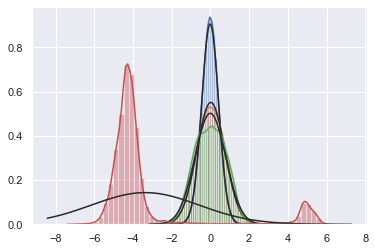

In [5]:
# current dataset corresponds to `wide` network option, so should remain Gaussian until the last couple layers:
view_layer('in-0', True)
view_layer('in-15', True)
view_layer('in-27', True)
view_layer('in-29', True)  # only 10 neurons, don't expect Gaussian

Of chief importance is the fixed-point $q^*$. We can find the approximate value with the following process: first, we numerically evaluate the integral expression for $q^{\ell+1}$ as a function of $q^{\ell}$ for a grid of points. We can optionally use this to plot $q^{\ell+1}$ and the unit slope, but all we really need is the nearest datapoint (in the aforementioned grid) to the intersection, which we find by identifying the index at which the difference between these two curves changes sign. Then, we apply linear interpolation to the corresponding line segments to approximate the precise value of the intersection.

Denote the endpoints of the line segment with unit slope $(x_1, y_1=x_1)$ and $(x_2, y_2=x_2)$, and the endpoints of the segment of the $q$-curve $(x_3=x_1, y_3)$ and $(x_4=x_2, y_4)$. Then Cramer's rule reduces to the following expression for the intersection point $x=y$:

\begin{equation}
x=\frac{(x_1y_4-x_2y_3)}{(x_1-x_2)-(y_3-y_4)}
\end{equation}

In [6]:
# recursive expression for the variances, eq. (14) in my blog:
def next_q(q, var_w=1, var_b=0):
    integral = integrate.quad(lambda z: np.exp(-z**2/2)*np.tanh(np.sqrt(q)*z)**2, -np.inf, np.inf)[0]/np.sqrt(2*np.pi)
    return var_w*integral + var_b

# compute q* given variances, and optionally plot q^{l+1} vs. q^l:
def find_qstar(var_weight, var_bias, plot = False, domain = 2):  # check between 0 and domain
    # grid of points for numerical sampling:
    points = np.arange(0,domain,0.05)
    qnew = [next_q(q, var_weight, var_bias) for q in points]
    
    # find index (i.e., datapoint) at which difference between curves changes sign:
    flip = np.argwhere(np.diff(np.sign(qnew-points)))[0][0]
    
    # extract line segments which contain the intersection:
    seg1 = points[flip:flip+2]
    seg2 = qnew[flip:flip+2]

    # intersection point x=4 via Cramer's rule:
    qstar = (seg1[0]*seg2[1] - seg1[1]*seg2[0])/(seg1[0] - seg1[1] - seg2[0] + seg2[1])
    
    if plot:
        line_df = pd.DataFrame({'q_l': points, 'q_{l+1}': points})
        theory_df = pd.DataFrame({'q_l': points, 'q_{l+1}': qnew})
        sns.lineplot('q_l', 'q_{l+1}', data=theory_df, marker='o');
        sns.lineplot('q_l', 'q_{l+1}', data=line_df, marker='o');
    
    return qstar

For example, for the case above, we have:

0.4174806682136245


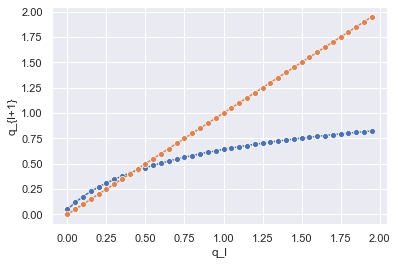

In [7]:
qstar = find_qstar(var_w, var_b, plot=True)
print(qstar)

Similarly, we would like to find the fixed point $\rho^*$, which is found by numerically solving a similar recursion relation, and then applying the flip-interpolation strategy above:

In [8]:
# recursive expression for the Pearson correlation coefficient, eq. (23) in my blog:
def next_rho(rho, qstar, var_w=1, var_b=0):
    sq = np.sqrt(qstar)
    bound = np.inf  # integration bound (should be np.inf)
    
    integral = integrate.dblquad(lambda x, y: np.exp(-x**2/2)*np.exp(-y**2/2)*np.tanh(sq*x)*np.tanh(sq*(rho*x+np.sqrt(1-rho**2)*y)),
                                 -bound, bound, lambda x: -bound, lambda x: bound)[0]/(2*np.pi)
    return (var_w*integral + var_b)/qstar


# compute rho* given q*, variances; optionally plot rho^{l+1} vs. rho^l:
def find_rhostar(qstar, var_weight, var_bias, plot = False):
    # grid of points for numerical sampling:
    points = np.arange(0,1.01,0.05)
    rhonew = [next_rho(rho, qstar, var_weight, var_bias) for rho in points]

    # find index (i.e., datapoint) at which difference between curves changes sign:
    where = np.argwhere(np.diff(np.sign(rhonew-points)))
    if where.size == 0:
        rhostar = 1
    else:
        flip = np.argwhere(np.diff(np.sign(rhonew-points)))[0][0]

        # extract line segments which contain the intersection:
        seg1 = points[flip:flip+2]
        seg2 = rhonew[flip:flip+2]

        # intersection point x=4 via Cramer's rule:
        rhostar = (seg1[0]*seg2[1] - seg1[1]*seg2[0])/(seg1[0] - seg1[1] - seg2[0] + seg2[1])
    
    if plot:
        line_df = pd.DataFrame({'rho_l': points, 'rho_{l+1}': points})
        theory_df = pd.DataFrame({'rho_l': points, 'rho_{l+1}': rhonew})
        sns.lineplot('rho_l', 'rho_{l+1}', data=theory_df, marker='o');
        sns.lineplot('rho_l', 'rho_{l+1}', data=line_df, marker='o');
    
    return rhostar

For example, for the $q^*$ value and associated variances above, we have:

1


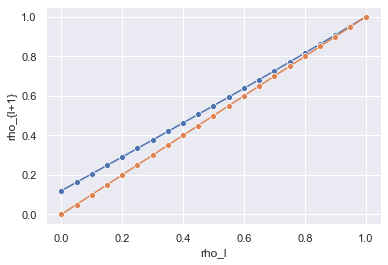

In [9]:
rhostar = find_rhostar(qstar, var_w, var_b, True)
print(rhostar)

With these values in hand, we can compute the theoretical correlation length, given by eq. (27) in my blog (which is eq. (9) in Schoenholz et al.):

In [10]:
# correlation length (for the Pearson correlation coefficient):
def correlation_length(rhostar, qstar, var_w=1):
    sq = np.sqrt(qstar)
    bound = 100  # integration bound (should be np.inf, but that causes overflow errors)
    
    integral = integrate.dblquad(lambda x, y: np.exp(-x**2/2)*np.exp(-y**2/2)*(1/np.cosh(sq*x))**2*(1/np.cosh(sq*(rhostar*x+np.sqrt(1-rhostar**2)*y))**2),
                                 -bound, bound, lambda x: -bound, lambda x: bound)[0]/(2*np.pi)
    return -1/np.log(var_w*integral)

In [11]:
correlation_length(rhostar, qstar, var_w)

15.889791697298854

# Probing fall-off
Theoretically, we should be able to train deeper networks at criticality, and they should all fall-off based on the correlation length. To see how our networks behave, we'll write a function that reads-in a grid-worth of accuracy data (optionally plotting the individual accuracies), and another that uses this function to make the desired scatterplot:

In [12]:
# automatically read and plot accuracies from a series of files **with the same variances**:
def read_and_plot_accs(base, start, stop, step, plot=True, write=False):
    # file names in format acc-{base}-{dd}.hdf5
    filenames = ['acc-{}-{}.hdf5'.format(base, dd) for dd in range(start, stop, step)]
    
    #print('Reading {} files: {}\n'.format(len(filenames), filenames))
    
    # get list of accuracies and corresponding depths:
    acc, depth = [], []
    for i in range(len(filenames)):
        # load data:
        acc_dict = read_accuracies(filenames[i])        
        
        acc.append(acc_dict['accuracies'])
        depth.append(acc_dict['depth'].item())

    # get variances from last file:
    var_w = acc_dict['var_weight'].item()
    var_b = acc_dict['var_bias'].item()
    
    if plot:   
        #plt.rcParams['figure.figsize'] = [9, 6]   # globally (!) adjust figure size 
        
        # plot each series, labelled by depth:
        list_dict = {'L = {}'.format(dd) : pd.Series(acc[i])
                     for i,dd in enumerate(depth)}
        df = pd.DataFrame(list_dict)
        acc_plot = df.plot()
        
        # format legend, title:
        acc_legend = acc_plot.legend(loc='upper left', bbox_to_anchor=(1,1))
        acc_plot.set_title('var_w = {}'.format(var_w))  # all var_w equal
        
        # optionally save plot as pdf:
        if write:
            plt.savefig(PATH_TO_OUTPUT+'plot-{}.pdf'.format(base), 
                        bbox_extra_artists=(acc_legend,), bbox_inches='tight')

    return acc, depth, var_w, var_b
        

In [13]:
# read-in accuracies using pre-defined function above, and use this to
# make scatterplot like fig. 5 in Schoenholz et al.:
def probe_falloff(base_list, start, stop, step, plot=True, write=False):
    # read accuracies, with plot suppressed:
    acc_list, dep_list, w_list, b_list = [], [], [], []
    for base in base_list:
        acc, dep, w, b = read_and_plot_accs(base, start, stop, step, False, False)
        
        # store final accuracy from run:
        acc_list.append([a[-1] for a in acc])
        
        # store list of depths, variances:
        dep_list.append(dep)
        w_list.append(w)
        b_list.append(b)
        
    # var_w gives x-values:
    x_vals = []
    for i in range(len(w_list)):
        # make len(acc_list[i]) copies of w_list[i]:
        x_vals.append([w_list[i]]*len(acc_list[i]))
    
    x_vals = np.array(x_vals).flatten()
                   
    # depths give y-values:
    y_vals = np.array(dep_list).flatten()
                   
    # accuracies give z-values (color):
    z_vals = np.array(acc_list).flatten()
    
    # optionally make scatterplot:
    if plot:
        scat_plot = plt.scatter(x_vals, y_vals, c=z_vals, cmap='rainbow', s=50)
        plt.colorbar(scat_plot)  # add colorbar as legend
        
        # add title, axes labels:
        plt.title('var_b = {}'.format(b_list[0]))  # all var_b equal
        plt.xlabel('var_w')
        plt.ylabel('depth')
        
        # optionally save plot as pdf:
        if write:
            # should all have same bias, so label with that:
            plt.savefig(PATH_TO_OUTPUT+'scatterplot-{}.pdf'.format(b_list[0]),)
    
    return x_vals, y_vals, z_vals, b_list

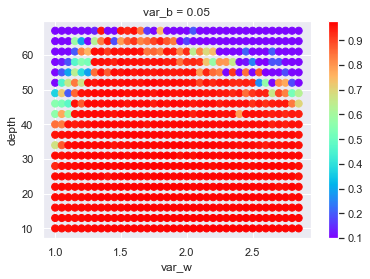

In [14]:
# read and plot:
var_list, dep_list, acc_list, b_list = probe_falloff([x for x in range(100,286,5)], 10, 70, 3, True, False)

 How does this compare with the theoretical value of the correlation length? We can easily compute this using the $q^*$, $\rho^*$, and `correlation_length` functions above:

In [15]:
# same range of var_w values as above, for given var_b:
test_w = np.arange(1.0, 2.86, 0.05)
test_b = 0.05

qstar_test = [find_qstar(ww, test_b, False) for ww in test_w]
#print('q* = ', qstar_test)

rhostar_test = [find_rhostar(qq, ww, test_b, False) for qq, ww in zip(qstar_test, test_w)]
#print('\nrho* = {}\n'.format(rhostar_test))

xi_vals = np.array([correlation_length(rr, qq, ww) for rr,qq,ww in zip(rhostar_test,qstar_test,test_w)])

In principle this should never be negative, but the numerics are such that the integral can be greater than 1 near the critical point, which makes $\xi<0$. Since we can't plot infinity, let's just replace this with double the largest positive value for visualization purposes:

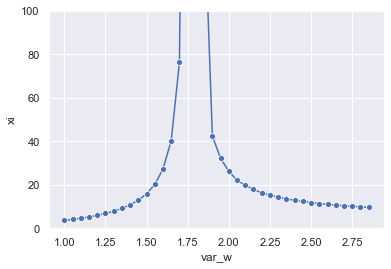

In [16]:
neg_index = np.where(np.array(xi_vals) < 0)[0].item()  # get index of negative value
xis = np.copy(xi_vals)
xis[neg_index] = 2*max(xi_vals)

xi_df = pd.DataFrame({'var_w': test_w, 'xi': xis})
xi_plot = sns.lineplot('var_w', 'xi', data=xi_df, marker='o');
xi_plot.set_ylim(0,100);

This is fine, but it would be nice to overlay the theoretical curve on the grid:

In [ ]:
# re-create and overlay above two plots:
def overlay_falloff(base_list, start, stop, step, write=False):
    # ************ load and process data for scatterplot: ************
    
    # read accuracies, with plot suppressed:
    acc_list, dep_list, w_list, b_list = [], [], [], []
    for base in base_list:
        acc, dep, w, b = read_and_plot_accs(base, start, stop, step, False, False)
        
        # store final accuracy from run:
        acc_list.append([a[-1] for a in acc])
        
        # store list of depths, variances:
        dep_list.append(dep)
        w_list.append(w)
        b_list.append(b)
        
    # var_w gives x-values:
    x_vals = []
    for i in range(len(w_list)):
        # make len(acc_list[i]) copies of w_list[i]:
        x_vals.append([w_list[i]]*len(acc_list[i]))
    
    x_vals = np.array(x_vals).flatten()
                   
    # depths give y-values:
    y_vals = np.array(dep_list).flatten()
                   
    # accuracies give z-values (color):
    z_vals = np.array(acc_list).flatten()
    
    # ************ process data for correlation length plot: ************
    
    qstar = [find_qstar(ww, b_list[0], False) for ww in w_list]  # all biases equal, so just use first
    
    rhostar = [find_rhostar(qq, ww, b_list[0], False) for qq, ww in zip(qstar, w_list)]
    
    xi_vals = np.array([correlation_length(rr, qq, ww) for rr,qq,ww in zip(rhostar, qstar, w_list)])   

    # ensure no negative elements (see comment about numerics near critical point above):
    artificial_xi = 2*max(xi_vals)  # overwrite negative values with this
    for i in range(xi_vals.size):
        if xi_vals[i] < 0:
            xi_vals[i] = artificial_xi
    
    # consider a few different multiples of the correlation length, for comparison with Schoenholz et al.:
    three_vals = [np.pi*xx for xx in xi_vals]
    six_vals = [2*np.pi*xx for xx in xi_vals]
        
    # ************ overlay correlation length plot on scatterplot: ************    
    
    # create combination figure:
    fig, ax1 = plt.subplots(figsize=(9,6))
    ax2 = ax1.twinx()  # share x axis
        
    # make scatterplot:
    ax1.set_xlabel(r'$\sigma_w^2$')
    ax1.set_ylabel('depth')
    scat_plot = ax1.scatter(x=x_vals, y=y_vals, c=z_vals, cmap='rainbow', s=120)  # does not return Axes object!
    ax1.tick_params(axis='y')
    # truncate for cleaner visuals:
    ax1.set_ylim(min(y_vals)-1, max(y_vals)+1)
    ax1.set_xlim(min(w_list)-0.05, max(w_list)+0.05)
    # ax1.set_title('Optional title here')
    cbar = plt.colorbar(scat_plot, label='accuracy')  # add colorbar as legend
    # control labels/ticks position colorbar:
    cbar.ax.yaxis.set_ticks_position('right')
    cbar.ax.yaxis.set_label_position('left')

    # overlay correlation length plot:
    xi_df = pd.DataFrame({'var_w': w_list, 'xi': xi_vals})
    ax2 = sns.lineplot('var_w', 'xi', data=xi_df, marker=None, color='black')
    # n.b., use None instead of False, else pdf still has white horizontal ticks
    
    xi3_df = pd.DataFrame({'var_w': w_list, 'xi': three_vals})
    sns.lineplot('var_w', 'xi', data=xi3_df, marker=None, color='grey')
    
    xi6_df = pd.DataFrame({'var_w': w_list, 'xi': six_vals})
    sns.lineplot('var_w', 'xi', data=xi6_df, marker=None, color='darkgrey')
    # n.b., darkgrey is *lighter* than grey, because what the fuck programmers
    
    # truncate to same range/domain:
    ax2.set_ylim(min(y_vals)-1, max(y_vals)+1)
    ax2.set_xlim(min(w_list)-0.05, max(w_list)+0.05)
    # turn off second labels, ticks, and grid:
    ax2.set_ylabel(None)
    ax2.grid(False)
    ax2.axis('off')

    # optionally save plot as pdf:
    if write:
        # should all have same bias, so label with that:
        plt.savefig(PATH_TO_OUTPUT+'scatterplot-{}.pdf'.format(b_list[0]),)
    
    return x_vals, y_vals, z_vals, b_list

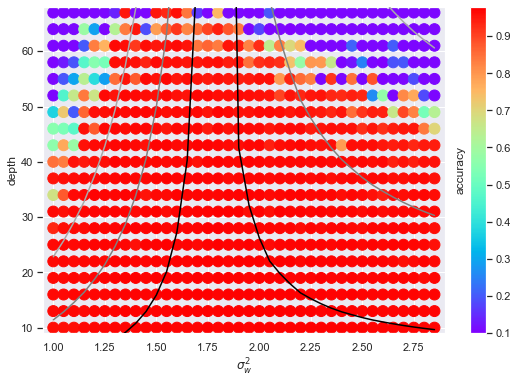

In [329]:
overlay_falloff([x for x in range(100,286,5)], 10, 70, 3, xis, False);